# Análise da métrica "número de comprovantes" de projetos culturais
---

Issue: [#170](https://github.com/lappis-unb/salic-ml/issues/170): Número total de comprovantes - Evoluir notebook comparando Gaussiana com LOF

## Objetivos

Realizar uma análise comparativa do número de comprovantes entre todos os projetos de um mesmo **produto cultural**. Nesta análise, será investigado se o número de comprovantes de um projeto cultural específico é anormal com relação aos demais projetos do mesmo produto cultural.

A metodolgia e modelos aplicados neste notebook para identificar projetos considerados anômalos com relação à métrica "número de comprovantes" é a mesma aplicada no notebook `notebooks/report/analysis_of_approved_funds.ipynb`, relativo à métrica "valor total aprovado para um projeto".

---
## Preparação

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### 1. Carregando dataset que relaciona projetos com suas respectivas categorias de "produto cultural"

In [2]:
df_budget = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df_budget.columns)
df_budget.head()

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto,cdCidade,cdEtapa
0,121051,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,Unidade,150,40.0,1.0,150.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
1,121051,100855,792883,Bonecos – Criação,3599,Verba,90,1.0,1.0,4000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,330455,2
2,121051,100855,792903,Produtor executivo,53,Verba,90,3.0,1.0,3000.0,...,2 - Produção / Execução,1,Artes Cênicas,11,Teatro,19,Espetáculo de Artes Cênicas,2010-02-19 11:53:49.387,355030,2
3,119968,98671,109095,Assistente de produção,1037,Verba,30,1.0,1.0,1000.0,...,1 - Pré-Produção / Preparação,3,Música,31,Música Popular Cantada,51,Apresentação Musical,2009-12-28 11:37:57.830,330455,1
4,112836,91695,116511,Designer,103,Mês,378,1.0,18.0,2000.0,...,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,17,Pesquisa,2009-05-21 10:48:48.790,431490,2


#### Visualizando amostra de produtos culturais

In [3]:
products = df_budget[['idProduto', 'Produto', 'PRONAC']].drop_duplicates()
products = products.groupby(['idProduto', 'Produto']).count()
products = products.rename(columns={'PRONAC' : 'numOccurrences'})
products = products.sort_values(by='numOccurrences', ascending=False)
print(products.shape)
products.head()

(75, 1)


,,numOccurrences
idProduto,Produto,
0,Administracao do Projeto,41568
19,Espetáculo de Artes Cênicas,10360
51,Apresentação Musical,8338
1,Livro,6476
18,Festival/Mostra,4944


#### Extraindo a relação de itens de projetos e seus "produtos culturais"

In [4]:
projects = df_budget[['idProduto', 'idPlanilhaItens', 'PRONAC']].drop_duplicates()
projects = projects.set_index(['PRONAC', 'idPlanilhaItens'])
print(projects.shape)
projects.head()

(1673527, 1)


idProduto
PRONAC idPlanilhaItens           
100855 131                     19
       3599                    19
       53                      19
98671  1037                    51
91695  103                     17

#### 2. Carregando dataset que relaciona itens de projetos com seus respetivos comprovantes

In [5]:
df_receipts = pd.read_csv('../../data/raw/planilha_comprovacao.csv', low_memory=False)
print(df_receipts.columns)
df_receipts.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento', 'IdPRONAC',
       'idSegmento', 'cdProduto', 'cdEtapa', 'cdUF', 'UF', 'cdCidade',
       'idPlanilhaItem', 'Item', 'DataProjeto', 'nrComprovante', 'nrSerie',
       'nrCNPJCPF', 'nmFornecedor', 'proponenteCgcCpf', 'tpDocumento',
       'dtPagamento', 'dtEmissao', 'tpFormaDePagamento',
       'nrDocumentoDePagamento', 'idArquivo', 'dsJustificativaProponente',
       'dsOcorrenciaDoTecnico', 'stItemAvaliado', 'stAvaliacao',
       'vlComprovacao'],
      dtype='object')


,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,IdPRONAC,idSegmento,cdProduto,cdEtapa,cdUF,UF,cdCidade,...,dtPagamento,dtEmissao,tpFormaDePagamento,nrDocumentoDePagamento,idArquivo,dsJustificativaProponente,dsOcorrenciaDoTecnico,stItemAvaliado,stAvaliacao,vlComprovacao
0,1012121,18552,4326,132451,71,1,1,35,SP,355030,...,2014-01-16 00:00:00,2013-03-27 00:00:00,Transferencia Bancaria,42501,410880,Elaboração de projeto gráfico do livro.,NaN,4,Aguardando analise,12000.0
1,1012121,18553,4332,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-04-30 00:00:00,Transferencia Bancaria,2945,410935,Reportagem e produção de textos para livro.,NaN,4,Aguardando analise,6000.0
2,1012121,18554,4755,132451,71,1,2,35,SP,355030,...,2014-01-28 00:00:00,2012-03-16 00:00:00,Transferencia Bancaria,31601,420731,Fotografia artística para o livro.,NaN,4,Aguardando analise,12000.0
3,1012121,18555,4334,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2013-08-27 00:00:00,Transferencia Bancaria,90201,410939,Tratamento de imagens para o livro.,NaN,4,Aguardando analise,6000.0
4,1012121,18556,4327,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-05-04 00:00:00,Transferencia Bancaria,2945,410917,Edição dos textos do livro.,NaN,4,Aguardando analise,8000.0


#### Extraindo os comprovantes identificados por item e projeto

In [6]:
receipts = df_receipts[['PRONAC', 'idComprovantePagamento', 'idPlanilhaItem']].drop_duplicates()
receipts = receipts.rename(columns={'idPlanilhaItem': 'idPlanilhaItens'})
receipts = receipts.set_index(['PRONAC', 'idPlanilhaItens'])
print(receipts.shape)
receipts.head()

(355659, 1)


idComprovantePagamento
PRONAC  idPlanilhaItens                        
1012121 43                                 4326
        91                                 4332
        143                                4755
        3204                               4334
        97                                 4327

#### 3. Gerando dataset contendo os dados do produto cultural, identificador do projeto e seu número de comprovantes

In [7]:
projects_receipts = receipts.join(projects)
projects_receipts = projects_receipts.groupby(['idProduto', 'PRONAC']).count()
projects_receipts = projects_receipts.rename(columns={'idComprovantePagamento': 'numReceipts'})
print(projects_receipts.shape)
projects_receipts.head()

(6766, 1)


numReceipts
idProduto PRONAC             
0.0       110107            4
          110131            5
          110152            1
          110170            3
          110283            9

---
## Desenvolvimento

Nesta etapa, será analisado o número de comprovantes de projetos para um produto cultural escolhido.

#### Esolhendo um produto cultural e gerando uma lista de número de comprovantes para os seus projetos

In [8]:
product = 0
product_projects = projects_receipts.loc[product]['numReceipts']
display(product_projects.head())

# Gross rounding to improve visualization
product_projects[product_projects > 400] = 400

PRONAC
110107    4
110131    5
110152    1
110170    3
110283    9
Name: numReceipts, dtype: int64

#### Gerando histograma dos dados acima

Média da distribuição: 18.78
Desvio padrão da distribuição: 39.12



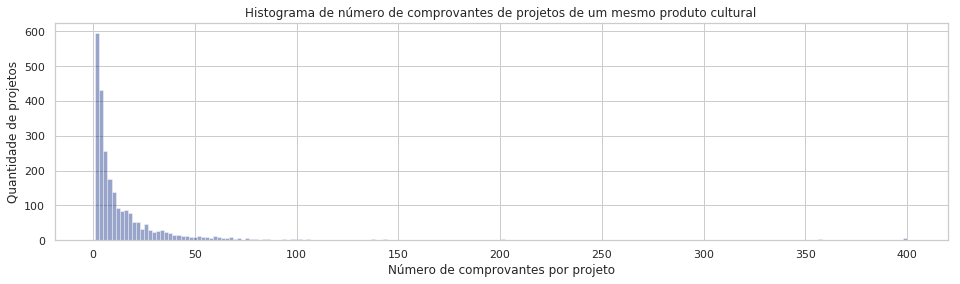

In [9]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(product_projects, bins=200, kde=False)
plt.title('Histograma de número de comprovantes de projetos de um mesmo produto cultural')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Número de comprovantes por projeto')
plt.grid(True)

expected_mean = np.mean(product_projects)
expected_std = np.std(product_projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [10]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(product_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
124007    16
153451     3
160112     8
153502    11
152421     2
Name: numReceipts, dtype: int64

PRONAC
1411766    20
127376     11
154899     26
170497      1
138048     33
Name: numReceipts, dtype: int64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [11]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        plt.plot(x,  bin_size * len(test_set) * model.model.pdf(x), label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('# receipts')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [12]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

#### Modelo Gaussiano

Tempo de treinamento: 0.014 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 3.37%


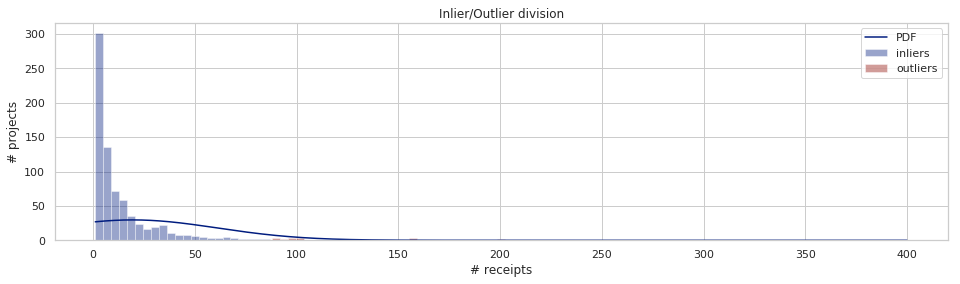

In [13]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=4)

#### Modelo Log-normal

Tempo de treinamento: 0.132 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 8.82%


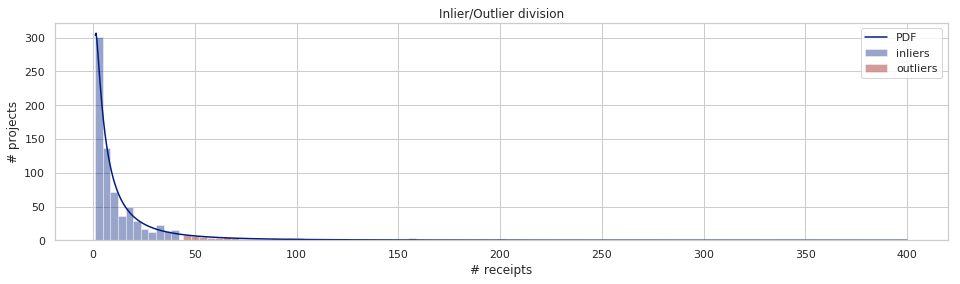

In [14]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=None):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        if self.transform:
            X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(), projects_train, projects_test, bin_size=4)

#### Modelo Gamma

Tempo de treinamento: 0.012 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 3.11%


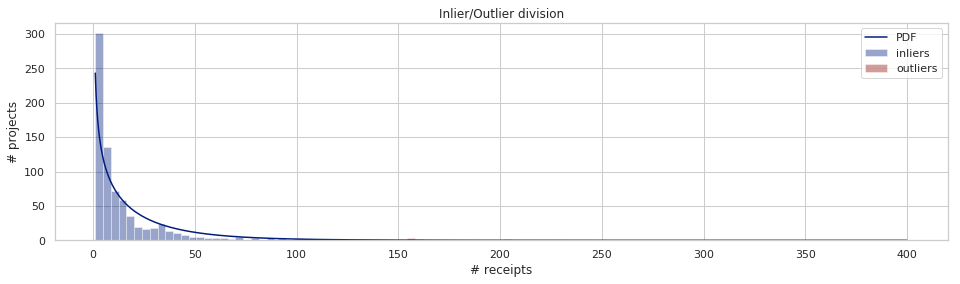

In [15]:
class Gamma:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=4)

#### Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.289 (s)
Tempo de teste: 0.161 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.39%


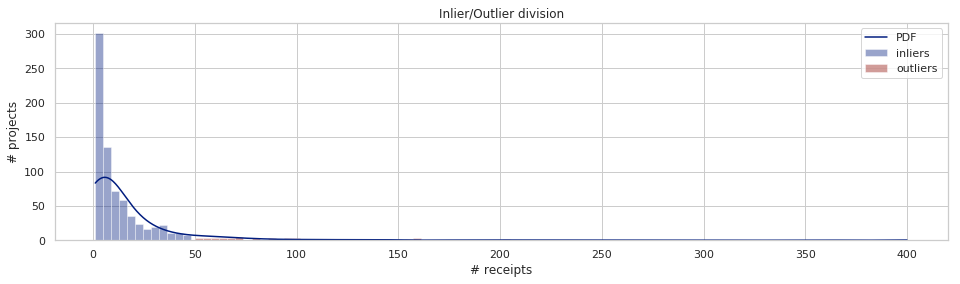

In [16]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=4)

#### Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 0.076 (s)
Tempo de teste: 0.009 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 18.29%


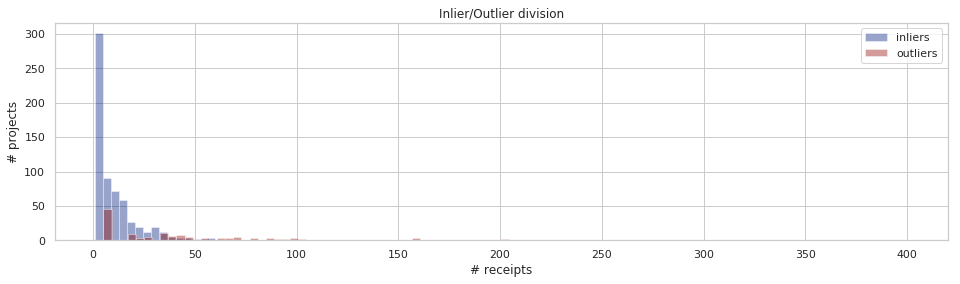

In [17]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=20):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=0.5)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(n_neighbors=100), projects_train, projects_test, bin_size=4)

#### Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [18]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(n_neighbors=100),
    'results': []
}]

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(product_projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        inlier_filter = (model['curve'].fit(projects_train).predict(projects_test))
        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)

Média Gaussian: 3.83%
Média Log-normal: 10.01%
Média Gamma: 3.82%
Média KDE-Gauss: 8.66%
Média LOF: 17.39%


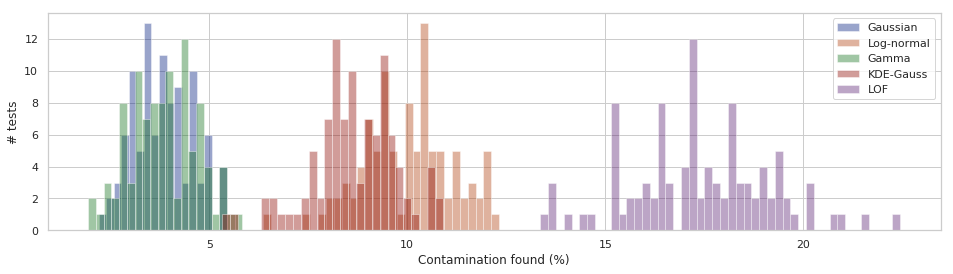

In [19]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.2
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

---
## Resultados

Os resultados foram analisados com base nos seguinte critérios: tempo de execução de treino/teste, efetividade do modelo com relação à taxa de contaminação encontrada, e efetividade do modelo com relação a quais amostras foram rotuladas como outliers.

#### Tempo de execução de treino e teste

O modelo mais rápido, tanto para treinamento, quanto para teste, é o da Distribuição Gaussiana, gastando 14ms para o treinamento e apenas 1ms para o teste. Os modelos de Distribuição Log-Normal, Distribuição Gamma e LOF gastaram, respectivamente, 132ms, 12ms e 76ms para treinamento e 2ms, 2ms e 9ms para teste. Já o modelo de Distribuição KDE obteve os piores resultados, com 289ms para treinamento e 161ms para teste.

#### Taxa de contaminação encontrada

Os resultados das 100 execuções de treino e teste realizadas mostram que os modelos de Distribuição Log-Normal, e a KDE tiveram as melhores acurácias, contudo a Distribuição Log-Normal se destacou. Já as Distribuições Gaussiana e Gamma detectaram, em média, menos da metade da contaminação esperada. O modelo LOF apresentou os piores resultados, aprensentando, em média, 1.7 vezes mais outliers que o esperado.

#### Quais amostras foram rotuladas como outliers

Nos modelos de detecção de anomalias baseada na aproximação da PDF por modelos de distribuição, fica claro que os projetos rotulados como outliers têm número de comprovantes muito acima da média, já o modelo de detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico, LOF, amostras com valores consideravelmente próximos à média da distribuição foram rotuladas como outliers, o que não parece fazer sentido para o contexto.

---
## Conclusões

O modelo de Distribuição Log-Normal apresentou ótimos resultados, tanto em tempo de execução quanto em acurácia, e é a opção mais adequada para a detecção de outliers no contexto apresentado. As distribuições Gaussiana e Gamma apresentaram acurácia bem piores que a Log-Normal e não são uma boa opção. O modelo KDE obteve um acurácia muito baixa e o LOF demanda um tempo muito elevado de treino e teste e são os modelos menos adequados para o contexto.

#### Trabalhos futuros

Escolheu-se um produto cultural específo e todo o estudo foi realizado com base nos dados daquele produto cultural. Um trabalho futuro é a realização das mesmas análises e generalização para os outros produtos culturais.